# Turn truth tables into degenerate graphs and visualize those graphs

## Imports

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import networkx as nx

## Truth Tables / Gates

### $A \land B$ gate

In [3]:
gate_states = [
    # A B
    [0, 0],
    [1, 0],
    [0, 1],
    [1, 1],
]

truth_vector = np.array([0, 0, 0, 1])


and_edges = [("A", "B"), ("B", "A")]
AND_gate = nx.MultiDiGraph()
AND_gate.add_edges_from(and_edges)

options = {"node_color": "red", "node_size": 400, "alpha": 0.4}
nx.draw_networkx(AND_gate, with_labels=True, **options)

Aside: Below three-component gate graphs are only one of many possible degenerate graph solutions, work in progress. weights can be added as edge components to list as well

### $(A \land B) \lor C$ gate

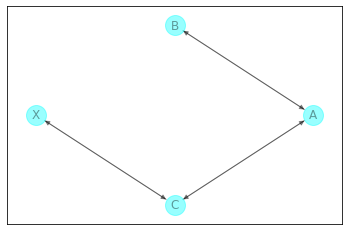

In [4]:
gate_states = [
    # A B C
    [0, 0, 0],
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1],
    [1, 1, 0],
    [1, 0, 1],
    [0, 1, 1],
    [1, 1, 1],
]

truth_vector = np.array([0, 0, 0, 1, 1, 1, 1, 1])

ANDOR_gate = nx.MultiDiGraph()
ANDOR_gate.add_edges_from(and_edges + [("X", "C"), ("C", "X"), ("A", "C"), ("C", "A")])

options = {"node_color": "cyan", "node_size": 400, "alpha": 0.4}
nx.draw_networkx(
    ANDOR_gate, nx.circular_layout(ANDOR_gate), with_labels=True, **options
)

# all x all matrix
column 8 is wrong

In [47]:
allxall = np.load("allxall.npy")
# fix column 8 for now
allxall[:,7] = (allxall[:,7] * 0.10)
# add axis labels
xlabels = ["BW3_A_sm", "BW3_B_sm","BW5_A_sm","BW5_B_sm","IL8_A_sm","IL8_B_sm","IL9_A_sm","IL9_B_sm","IL14A_sm","IL14_B_sm"]
ylabels = ["BW3_B_lg", "BW3_A_lg","BW5_B_lg","BW5_A_lg","IL8_B_lg","IL8_A_lg","IL9_B_lg","IL9_A_lg","IL14B_lg","IL14_A_lg"]

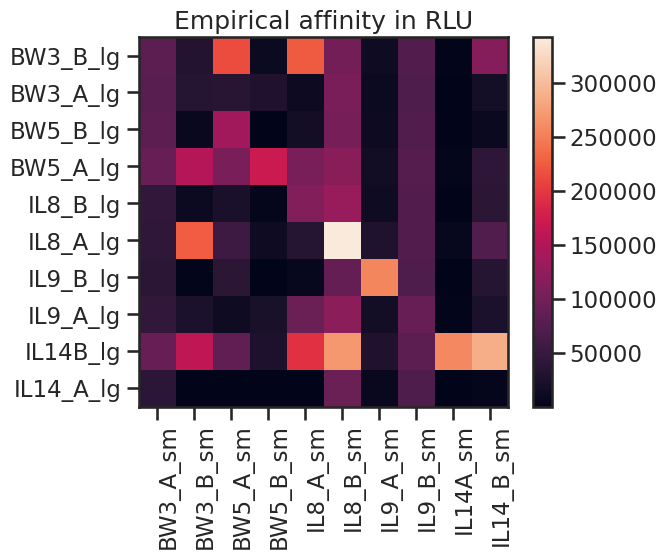

In [48]:
sns.set(
    context="talk",
    font_scale=1,  # make the font larger; default is pretty small
    style="ticks",  # make the background white with black lines
    palette="colorblind",  # a color palette that is colorblind friendly!
)

fig, ax = plt.subplots()
mat = ax.imshow(allxall)
ax.set_title("Empirical affinity in RLU")
plt.colorbar(mappable=mat)
# We want to show all ticks...
ax.set_xticks(np.arange(allxall.shape[0]))
ax.set_yticks(np.arange(allxall.shape[1]))
# ... and label them with the respective list entries
ax.set_xticklabels(xlabels)
ax.set_yticklabels(ylabels)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")
plt.show()